In [1]:
%pip install scipy
%pip install matplotlib
%pip install ipywidgets
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


interactive(children=(IntSlider(value=100, description='V0 (Volts)', max=1000, step=5), FloatLogSlider(value=0…

<function matplotlib.pyplot.show(close=None, block=None)>

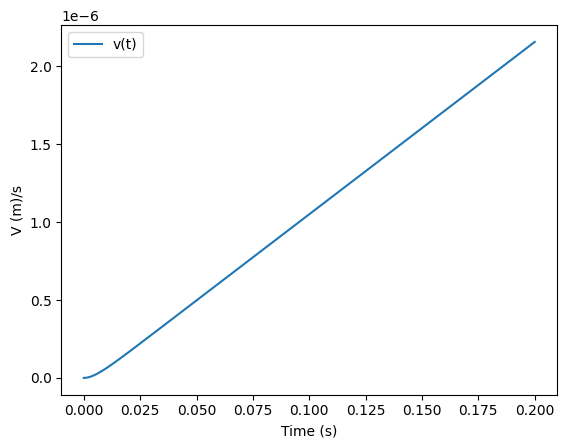

In [4]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, FloatLogSlider, IntSlider
from scipy.integrate import solve_ivp, cumulative_trapezoid
import numpy as np
from collections import namedtuple
import plots

mu_0 = 4 * np.pi * 1e-7  # Permeability of free space in T·m/A

# Projectile properties
proj_diameter = 0.005  # Diameter in meters
proj_length = 0.010  # Length in meters
iron_density = 7870  # Density of iron in kg/m^3

SimulationParameters = namedtuple('SimulationParameters',
                                  ['init_volts',
                                   'capacitance',
                                   'resistance',
                                   'num_turns',
                                   'coil_diameter',
                                   'coil_length',
                                   'slug_diameter',
                                   'slug_length',
                                   'duration_s',
                                  ])

SimulationSolution = namedtuple('SimulationSolution',
                                ['time',
                                 'velocity',
                                 'acceleration',
                                 'voltage',
                                 'current'])

# Define the differential equation for the RLC circuit
def sys_model(t, y, params):
    # Destructure the state vector
    [velocity, acceleration, voltage, current] = y

    # Velocity
    dxdt=velocity
    
    # Rate of change in voltage
    dVdt = current / params.capacitance

    # Compute inductance, L
    coil_area = np.pi * (params.coil_diameter / 2) ** 2  # Coil cross-section, in m^2
    L = (params.num_turns ** 2 * mu_0 * coil_area) / params.coil_length  # Inductance in Henrys  

    # Rate of change in current 
    dIdt = -(params.resistance * current + voltage) / L

    # Compute magnetic field density
    turns_density=params.num_turns/params.coil_length
    B = mu_0 * turns_density * current

    # Compute force from magnetism
    # The magnetic susceptibility of soft iron typically ranges from 1e3 to 1e5, 
    #   depending on the specific alloy and its treatment.
    chi_iron = 1000
    slug_volume = np.pi * (params.slug_diameter/2) ** 2 * params.slug_length  # Volume in cubic meters
    slug_mass = iron_density * slug_volume  # Mass in kg
    F = (chi_iron * B**2 * slug_volume)/(2*mu_0*(1+chi_iron)**2)
    
    # Compute acceleration of the projectile
    dvdt = F / slug_mass
    return [dxdt, dvdt, dVdt, dIdt]

def run_sim(params):
    # Initial conditions
    init_conditions = [0, 0, -params.init_volts, 0]
    print(init_conditions)
    print(params)
    t_span = (0, params.duration_s)  # Simulation time span
    t_eval = np.arange(0,params.duration_s, 1e-6)  # Set simulation time step
    # Solve the differential equation
    return solve_ivp(
        sys_model,
        t_span,
        init_conditions,
        t_eval=t_eval,
        args=(params,))

solution=None
simulationParameters=None

def solve_and_plot(V0, C, R, N, D, l, sd, sl, duration_s):
    global simulationParameters 
    global solution
    simulationParameters = SimulationParameters(init_volts=V0,
                                     capacitance=C,
                                     resistance=R,
                                     num_turns=N,
                                     coil_diameter=D,
                                     coil_length=l,
                                     slug_diameter=sd,
                                     slug_length=sl,
                                     duration_s=duration_s)
    s = run_sim(simulationParameters)
    [velocity, acceleration, voltage, current] = s.y
    solution=SimulationSolution(
        s.t,
        velocity,
        acceleration,
        voltage,
       current) 
    plots.plot_circuit(solution.time, velocity, acceleration, voltage, current)
    plots.plot_velocity(solution.time, acceleration)

plots.start(solve_and_plot)

#Test integration
vel2 = cumulative_trapezoid(solution.acceleration, solution.time)
# Adjust the time array to match the length of the integrated array
time_adjusted = solution.time[:-1]
position = cumulative_trapezoid(solution.velocity, solution.time)
plt.plot(time_adjusted, vel2, label='v(t)')
plt.xlabel('Time (s)')
plt.ylabel('V (m)/s')
plt.legend()
plt.show